In [1]:
dataset_base_path = r'/Users/piikn/ridho/dataset/processed'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import describe
from collections import Counter
from IPython.display import display
from time import time #time stamp for all processing time

%matplotlib inline

In [3]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

2. Prepocesing data

In [4]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [5]:
#fitur yang nilainya 0 dicari 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [6]:
#fitur yang nilainya 0 dihapus
X = X.drop(columns=features_no_variance)

In [7]:
#fitur timestamp dan dst_port bertipe obyek, maka dihapus saja
X = X.drop(columns=['timestamp', 'dst_port'])

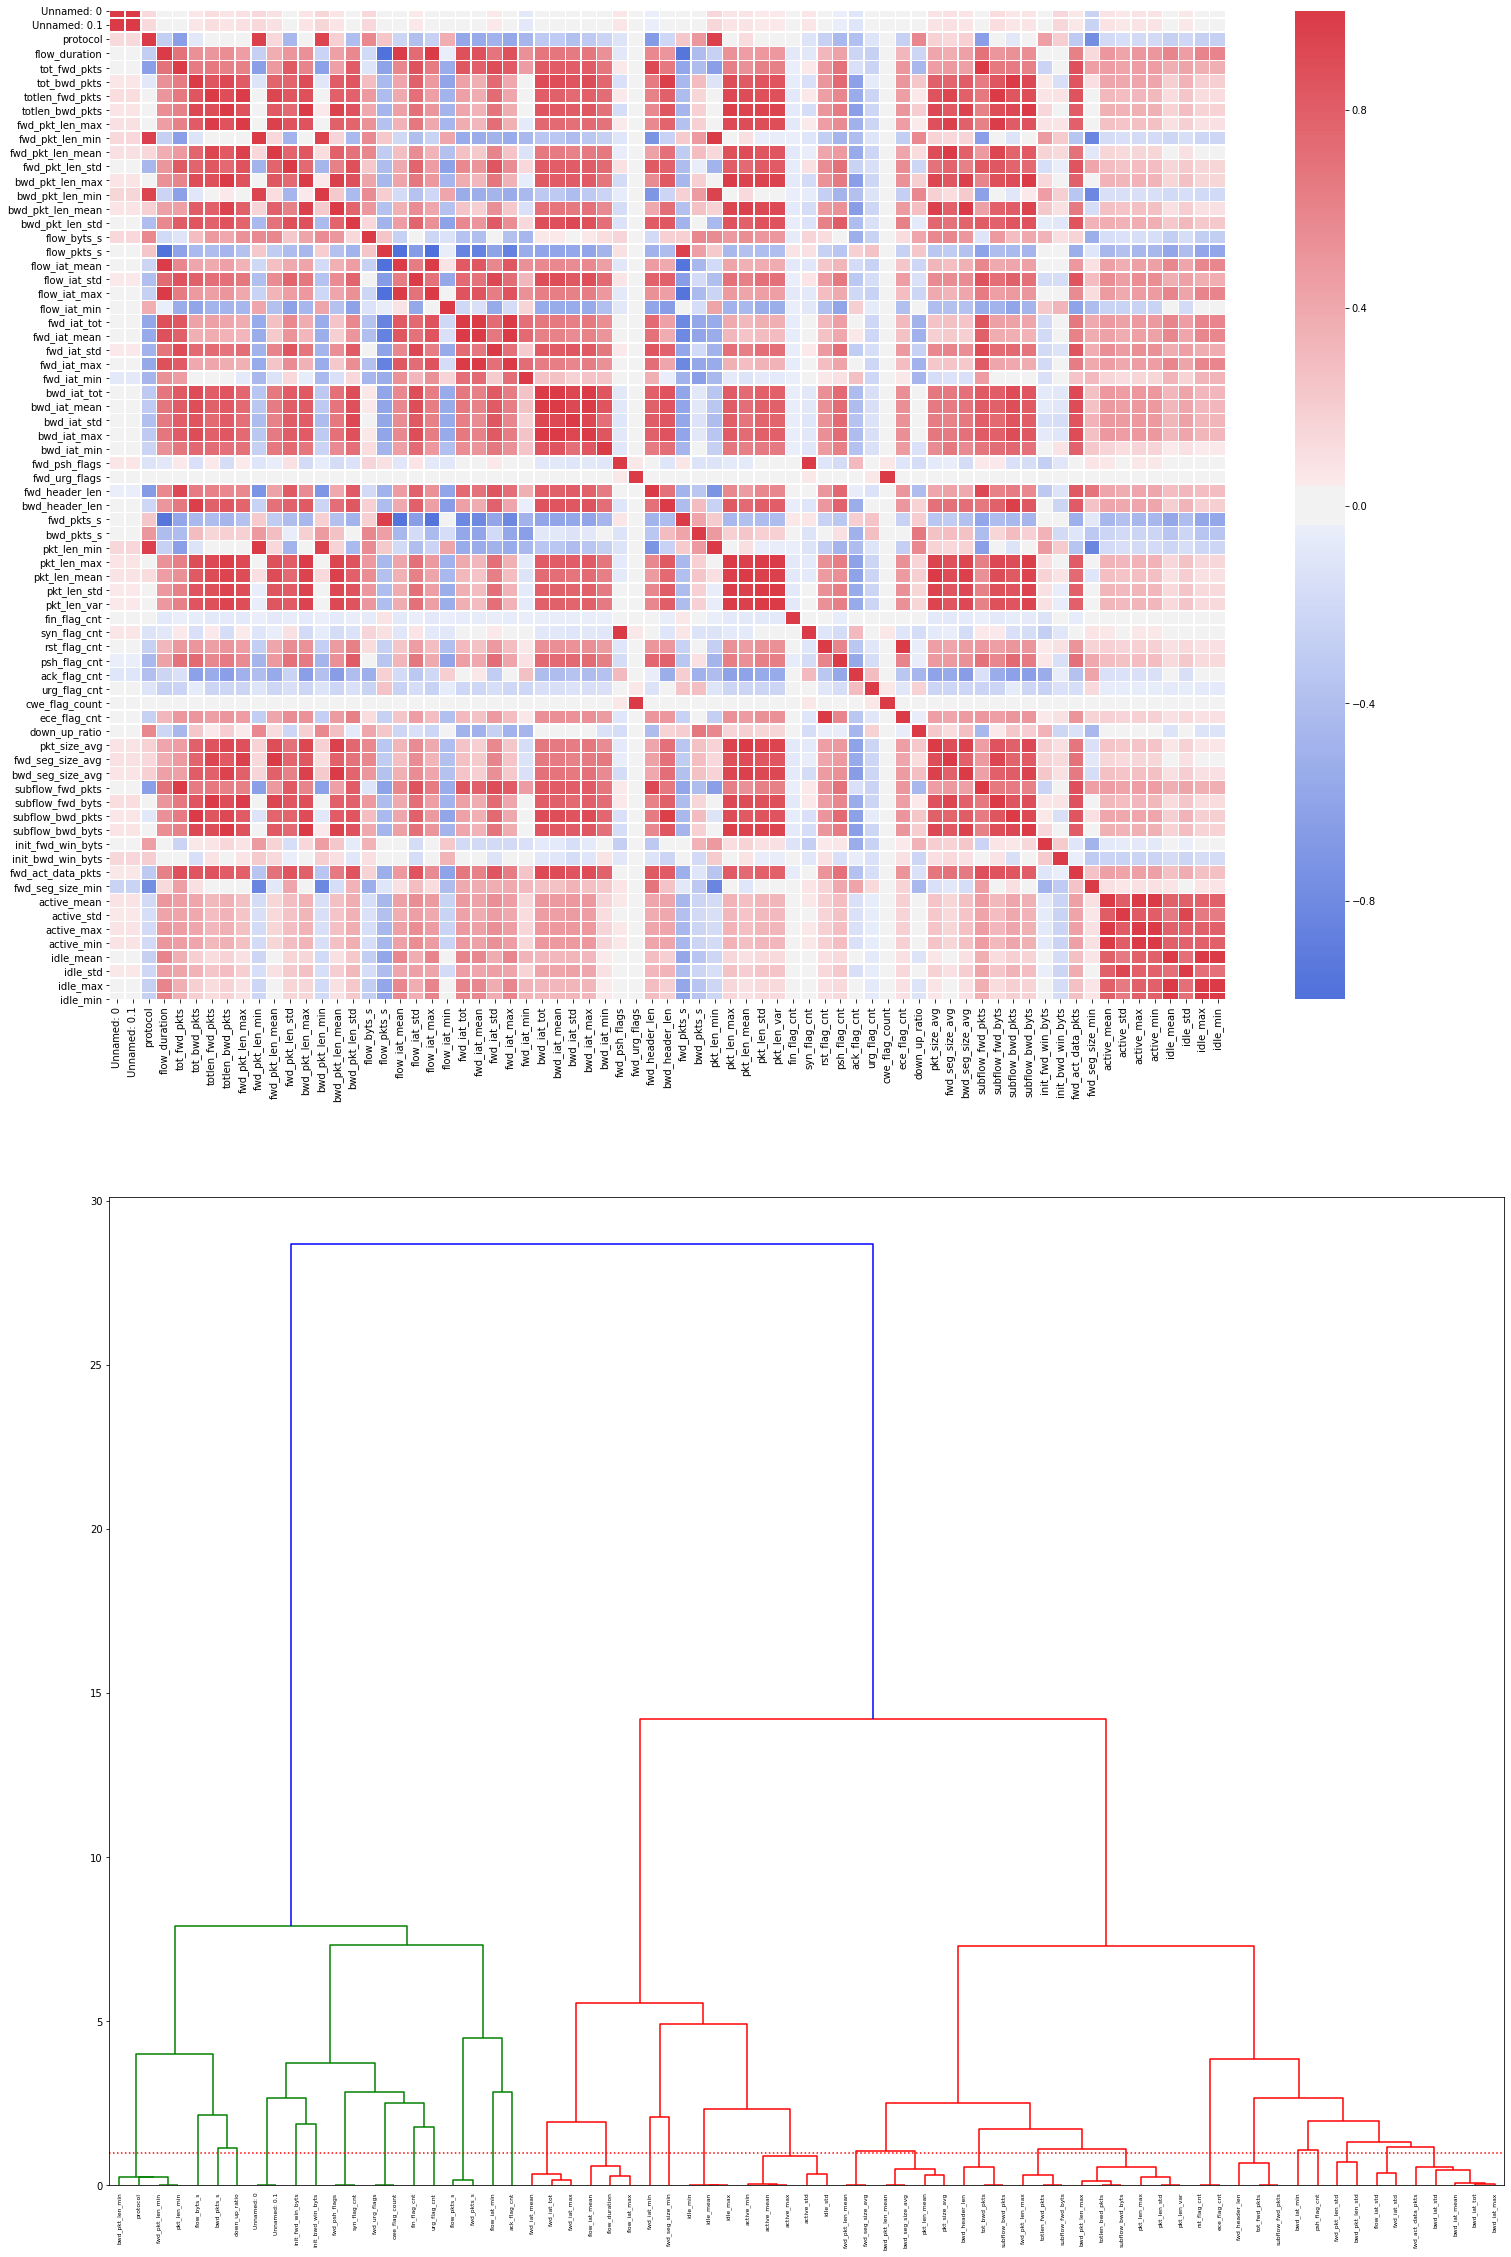

In [8]:
#Mencari fitur yang memiliki korelasi yang tinggi menggunakan Spearman rank-Order Corelation
import seaborn as sns
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

In [9]:
# The heatmap demonstrates that the dataset has a fair amount of features with high correlation amongst each other. 
#In order to remove redundant features the cluster distance threshold of 1 is used to pick features from their respective clusters
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0            Unnamed: 0
1              protocol
2         flow_duration
3          tot_fwd_pkts
4          tot_bwd_pkts
5       totlen_fwd_pkts
6       totlen_bwd_pkts
7      fwd_pkt_len_mean
8       fwd_pkt_len_std
9      bwd_pkt_len_mean
10          flow_byts_s
11          flow_pkts_s
12         flow_iat_std
13         flow_iat_min
14          fwd_iat_tot
15          fwd_iat_min
16          bwd_iat_tot
17          bwd_iat_min
18        fwd_psh_flags
19        fwd_urg_flags
20           bwd_pkts_s
21         fin_flag_cnt
22         rst_flag_cnt
23         psh_flag_cnt
24         ack_flag_cnt
25         urg_flag_cnt
26        down_up_ratio
27    init_fwd_win_byts
28    init_bwd_win_byts
29     fwd_seg_size_min
30          active_mean
31            idle_mean
dtype: object

In [10]:
#Fitur yang memiliki korelasi tinggi antar sesamanya dihapus

X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 32


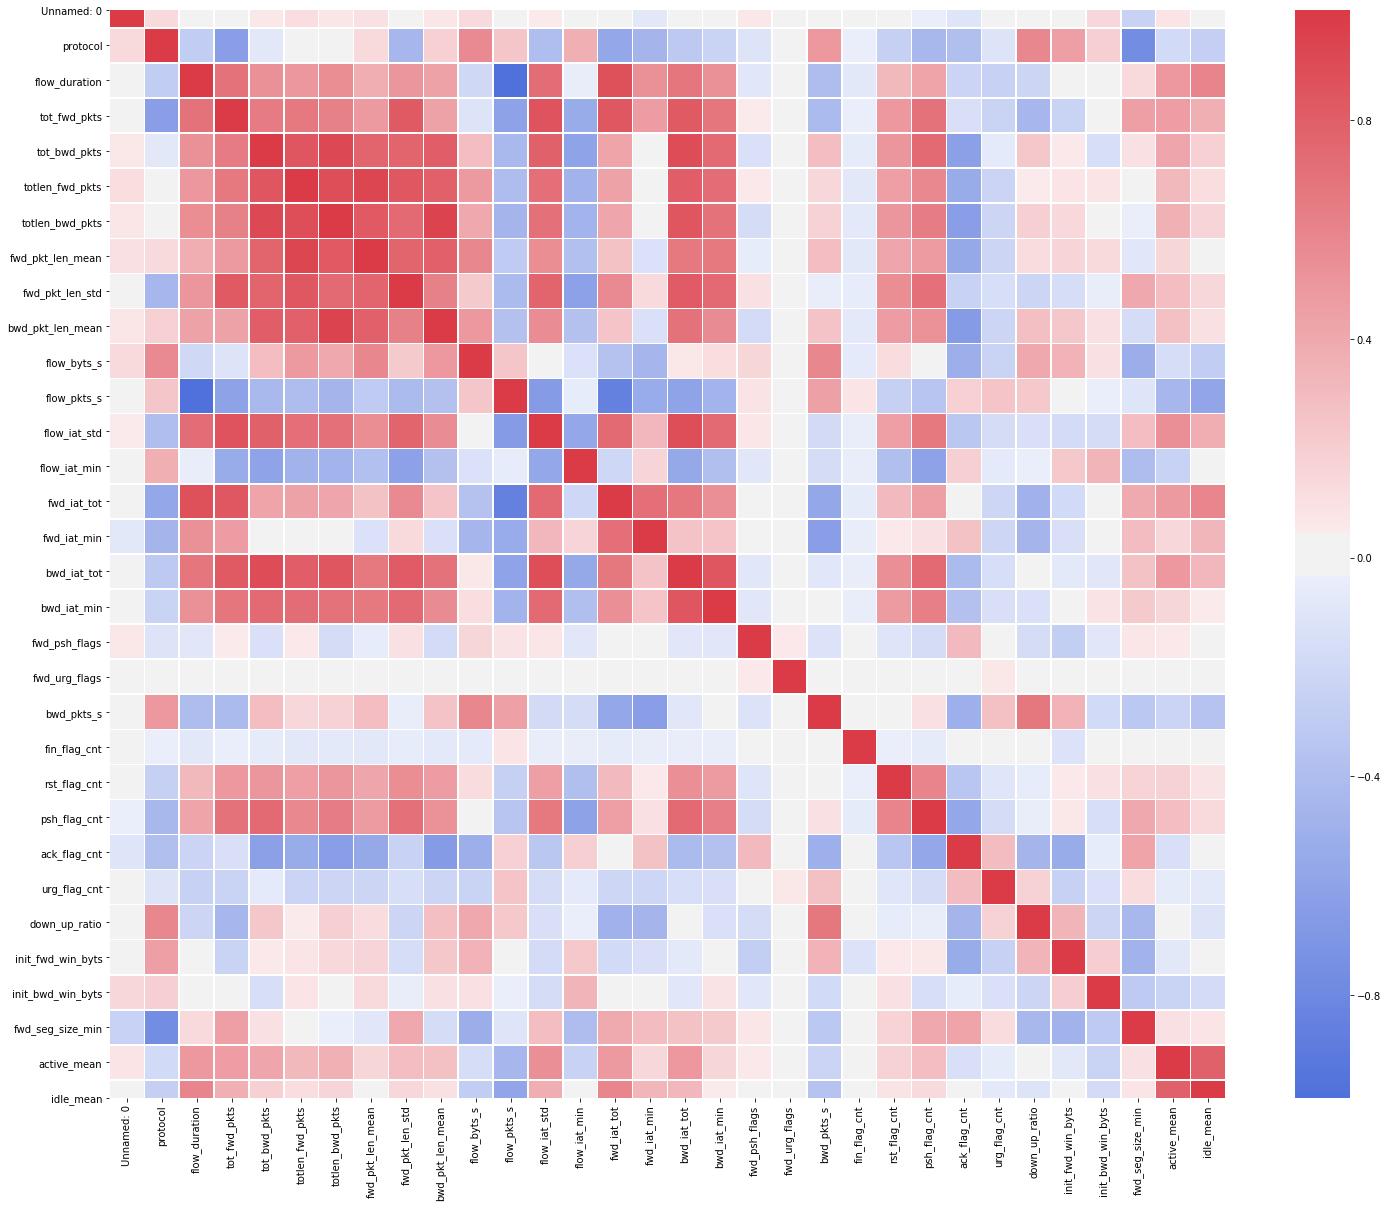

In [11]:

corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

In [12]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

In [13]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [14]:
y.label.value_counts()

Benign                      13484708
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193360
SSH-Bruteforce                187589
Infilteration                 161934
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: label, dtype: int64

In [15]:
percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.8307


## 4. Classifiers

In [16]:
## 1. baseline clasifier (dummy clasifier)

start_time = time()
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_dummy, X_train, y_train.label_is_attack, cls_dummy.predict(X_train))
print_report('Eval', cls_dummy, X_eval, y_eval.label_is_attack, cls_dummy.predict(X_eval))
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report (Train):


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91  10787766
           1       0.00      0.00      0.00   2198588

    accuracy                           0.83  12986354
   macro avg       0.42      0.50      0.45  12986354
weighted avg       0.69      0.83      0.75  12986354

Avg Precision Score: 0.16929986661383173


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91   1348471
           1       0.00      0.00      0.00    274823

    accuracy                           0.83   1623294
   macro avg       0.42      0.50      0.45   1623294
weighted avg       0.69      0.83      0.75   1623294

Avg Precision Score: 0.16929958467166145


Time to fit Data Train
0:00:00.55


In [17]:
scaler = StandardScaler()
scaler.fit(X_train_oh)

StandardScaler(copy=True, with_mean=True, with_std=True)

Classification Report (Train):


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00  10787766
           1       0.17      1.00      0.29   2198588

    accuracy                           0.17  12986354
   macro avg       0.08      0.50      0.14  12986354
weighted avg       0.03      0.17      0.05  12986354

Avg Precision Score: 0.16929986661383173


Classification Report (Eval):


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00   1348471
           1       0.17      1.00      0.29    274823

    accuracy                           0.17   1623294
   macro avg       0.08      0.50      0.14   1623294
weighted avg       0.03      0.17      0.05   1623294

Avg Precision Score: 0.16929958467166145


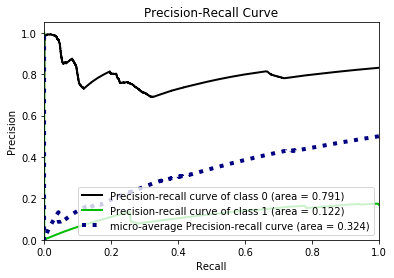



Time to fit Data Train
0:00:09.95


In [19]:
## 2. Gaussian Naive Bayes
start_time = time()
cls_nb = GaussianNB()
cls_nb.fit(X_train_oh, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
##print_report('Train', cls_nb, X_train, y_train.label_is_attack, cls_nb.predict(X_train))
##print_report('Eval', cls_nb, X_eval, y_eval.label_is_attack, cls_nb.predict(X_eval))
print_report('Train', cls_nb, scaler.transform(X_train_oh), y_train.label_is_attack, cls_nb.predict(scaler.transform(X_train_oh)))
print_report('Eval', cls_nb, scaler.transform(X_eval_oh), y_eval.label_is_attack, cls_nb.predict(scaler.transform(X_eval_oh)), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

In [ ]:
# SVM
start_time = time()
cls_svm = SVC(kernel='rbf', C=1 , gamma=1)
cls_svm.fit(X_train_oh, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_svm, scaler.transform(X_train_oh), y_train.label_is_attack, cls_svm.predict(scaler.transform(X_train_oh)))
print_report('Eval', cls_svm, scaler.transform(X_eval_oh), y_eval.label_is_attack, cls_svm.predict(scaler.transform(X_eval_oh)), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 981 seconds


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 16.4min finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97  10787766
           1       0.87      0.83      0.85   2198588

    accuracy                           0.95  12986354
   macro avg       0.92      0.90      0.91  12986354
weighted avg       0.95      0.95      0.95  12986354

Avg Precision Score: 0.7507694447084944


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   1348471
           1       0.87      0.83      0.85    274823

    accuracy                           0.95   1623294
   macro avg       0.92      0.90      0.91   1623294
weighted avg       0.95      0.95      0.95   1623294

Avg Precision Score: 0.7513633719723464


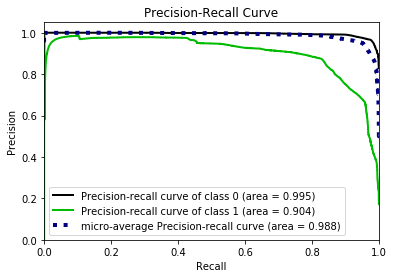



Total operation time: =  1176.0935213565826 seconds


In [22]:
## 3. Log Regression from scikit-learn with default value
start_time = time()
cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr.fit(scaler.transform(X_train_oh), y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_lr, scaler.transform(X_train_oh), y_train.label_is_attack, cls_lr.predict(scaler.transform(X_train_oh)))
print_report('Eval', cls_lr, scaler.transform(X_eval_oh), y_eval.label_is_attack, cls_lr.predict(scaler.transform(X_eval_oh)), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   50.1s finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  10787766
           1       1.00      1.00      1.00   2198588

    accuracy                           1.00  12986354
   macro avg       1.00      1.00      1.00  12986354
weighted avg       1.00      1.00      1.00  12986354

Avg Precision Score: 0.9999636438043432




[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.1s finished


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1348471
           1       0.99      0.96      0.98    274823

    accuracy                           0.99   1623294
   macro avg       0.99      0.98      0.99   1623294
weighted avg       0.99      0.99      0.99   1623294

Avg Precision Score: 0.9598476682724612


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.3s finished


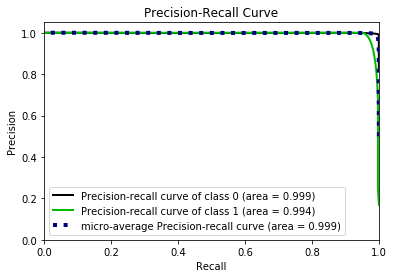



Total operation time: =  2593.7797746658325 seconds


In [23]:
## 4. RandomForest form scikit-learn with default value
start_time = time()
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
cls_forest.fit(X_train_oh, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_forest, X_train_oh, y_train.label_is_attack, cls_forest.predict(X_train_oh))
print_report('Eval', cls_forest, X_eval_oh, y_eval.label_is_attack, cls_forest.predict(X_eval_oh), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

In [24]:
## 5. Gradient Boosting form CatBoost
train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [25]:
start_time = time()
minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

cls_cb.fit(train_pool, eval_set=eval_pool)
end_time=time()
total=end_time-start_time

Learning rate set to 0.031833
0:	learn: 0.9417667	test: 0.9415260	best: 0.9415260 (0)	total: 583ms	remaining: 9m 42s
1:	learn: 0.9468604	test: 0.9464965	best: 0.9464965 (1)	total: 1.11s	remaining: 9m 15s
2:	learn: 0.9463105	test: 0.9460089	best: 0.9464965 (1)	total: 1.69s	remaining: 9m 20s
3:	learn: 0.9443547	test: 0.9441313	best: 0.9464965 (1)	total: 2.2s	remaining: 9m 8s
4:	learn: 0.9417253	test: 0.9416788	best: 0.9464965 (1)	total: 2.72s	remaining: 9m 1s
5:	learn: 0.9435383	test: 0.9433999	best: 0.9464965 (1)	total: 3.29s	remaining: 9m 5s
6:	learn: 0.9430980	test: 0.9429597	best: 0.9464965 (1)	total: 3.81s	remaining: 9m
7:	learn: 0.9452116	test: 0.9451174	best: 0.9464965 (1)	total: 4.34s	remaining: 8m 58s
8:	learn: 0.9451120	test: 0.9450555	best: 0.9464965 (1)	total: 4.86s	remaining: 8m 55s
9:	learn: 0.9420919	test: 0.9420354	best: 0.9464965 (1)	total: 5.41s	remaining: 8m 56s
10:	learn: 0.9454341	test: 0.9453794	best: 0.9464965 (1)	total: 5.93s	remaining: 8m 53s
11:	learn: 0.9433081

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  10787766
           1       0.95      0.97      0.96   2198588

    accuracy                           0.99  12986354
   macro avg       0.97      0.98      0.98  12986354
weighted avg       0.99      0.99      0.99  12986354

Avg Precision Score: 0.9266615022146119


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.95      0.97      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.97      0.98      0.98   1623294
weighted avg       0.99      0.99      0.99   1623294

Avg Precision Score: 0.9265939529253453


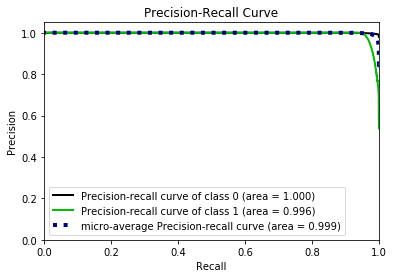



Total operation time: =  4797.104732513428 seconds


In [26]:
print_report('Train', cls_cb, train_pool, y_train.label_is_attack, cls_cb.predict(train_pool))
print_report('Eval', cls_cb, eval_pool, y_eval.label_is_attack, cls_cb.predict(eval_pool), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|
|z|0.00|0.00|0.00|0|0|

Gradient Boost performed best of all models and will be used as the final estimator.

In [12]:
estimator = cls_cb